In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import datetime as dt
import timeit
import datetime
from datetime import timedelta
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 8))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            # plt.show(block=False)
            plt.draw()


def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, clusters=None, alpha=1, illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(30, 22))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2],
                            alpha=alpha, color='w', marker='*', s=5)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(
                        X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                clusters_color = {0: 'red', 1: 'blue', 2: 'yellow'}
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i], color=clusters_color[clusters[i]],
                             fontsize='20', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            #plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            #plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)), fontsize=25)
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)), fontsize=25)

            plt.title("Projection des individus (sur F{} et F{})".format(
                d1+1, d2+1), fontsize=35)
            # plt.show(block=False)
            plt.draw()


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    # plt.show(block=False)
    plt.draw()


def plot_dendrogram(Z, names):
    plt.figure(figsize=(50, 60))
    # plt.rcParams["figure.figsize"]=[50,60]
    # plt.style.use('default')
    plt.title('Hierarchical Clustering Dendrogram', fontsize=100)
    plt.ylabel('Distance', fontsize=70)
    plt.yticks(fontsize = 40,color='k')
    dendrogram(
        Z,
        labels=names,
        orientation='top', leaf_font_size=20, color_threshold=7.32,
    )
    plt.draw()

La fonction data_sli(date_model) est parametrée pour fonctionner avec le dataset orders_data contenant une commande unique par   ligne afin de creer un dataset de sortie contenant les variables numeriques(note_moy, Monetary,qtés, Recency    
et Frequency) relatives a chaque client(en index) sur une periode précise qui debute a la date  
la plus ancienne du dataset ('2017-01-05 11:56:06') et termine a la date definie en entree au format '2018-08-30'(date_model)  

In [1]:
def data_sli(date_model='2018-08-30'):
    now = dt.datetime(2018, 8, 30)
    
    dataset = orders_data[['order_id', 'customer_id', 'customer_unique_id', 'order_item_id', 'total_price', 'review_score',
                           'order_purchase_timestamp']].copy()
    
    dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])
    
    dataset = dataset[dataset['order_purchase_timestamp'] < date_model]
    
    dataset = dataset.groupby('customer_unique_id').agg(note_moy=('review_score', np.mean),
                                                        Monetary=('total_price', np.sum),
                                                        qtés=('order_item_id', np.sum),
                                                        Recency=('order_purchase_timestamp', max),
                                                        Frequency=('customer_id', len))
    dataset['Recency'] = now - dataset['Recency']
    dataset['Recency'] = dataset['Recency'].dt.days
    
    return dataset


def summary(df):
    display(df.head())
    print('-'*100)
    display(df.info())
    print('-'*100)
    display(df.describe([0.01,0.25,0.50,0.75,0.99]))
    
    
def qualit(donnees):
    print("nb de lignes x nb de colonnes : ", donnees.shape, ".\n")
    print("% de données manquantes :\n", (donnees.isna().sum() /
          len(donnees) * 100).sort_values(ascending=False), "\n")
    print("nb de lignes dupliquées :", donnees.duplicated().sum(), ".\n")

### Chargement des données de Commandes

In [3]:
orders_data = pd.read_csv('orders_data.csv', delimiter = ',', encoding="utf8",index_col = 0)

In [4]:
print(orders_data.shape)
orders_data.head()

(95568, 7)


order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

                 customer_unique_id  order_item_id  total_price  review_score  \
0  871766c5855e863f6eccc05f988b23cb              1        58.90           5.0   
1  eb28e67c4c0b83846050ddfb8a35d051              1       239.90           4.0   
2  3818d81c6709e39d06b2738a8d3a2474              1       199.00           5.0   
3  af861d436cfc08b2c2ddefd0ba074622              1        12.99           4.0   
4  64b576fb70d441e8f1b2d7d446e483c5              1       199.90           5.0   

  order_purchase_timestamp  
0      2017-09-13 08:59:02  
1      2017-04-26 10:53:06  
2      2018-01-14 14:33:31  
3      2018-08-08 10:00:35  
4      2017-02-04 13:57:51

#### Affichage interval temporel du dataset

In [5]:
orders_data.order_purchase_timestamp.min(),orders_data.order_purchase_timestamp.max()

('2017-01-05 11:56:06', '2018-08-29 15:00:37')

#### Chargement de la totalité des données clients (jusqu'au 2018-8-30)

In [6]:
num_cust = data_sli('2018-8-30')

print(num_cust.shape)
num_cust.head()

(92504, 5)


note_moy  Monetary  qtés  Recency  Frequency
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2       5.0    129.90     1      111          1
0000b849f77a49e4a4ce2b2a4ca5be3f       4.0     18.90     1      114          1
0000f46a3911fa3c0805444483337064       3.0     69.00     1      537          1
0000f6ccb0745a6a4b88665a16c9f078       4.0     25.99     1      321          1
0004aac84e0df4da2b147fca70cf8255       5.0    180.00     1      288          1

#### Dataset ne contenant que les variables RFM

#### Chargement des variables RFM

In [7]:
rfm = num_cust[['Recency', 'Frequency', 'Monetary']].copy()
print(rfm.shape)
rfm.head()

(92504, 3)


Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90
0000f46a3911fa3c0805444483337064      537          1     69.00
0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99
0004aac84e0df4da2b147fca70cf8255      288          1    180.00

In [8]:
rfm.describe()

Recency     Frequency      Monetary
count  92504.000000  92504.000000  92504.000000
mean     236.099563      1.033123    147.600478
std      150.962701      0.208324    242.754956
min        0.000000      1.000000      0.850000
25%      114.000000      1.000000     48.900000
50%      218.000000      1.000000     89.900000
75%      344.000000      1.000000    159.770000
max      601.000000     15.000000  13440.000000

### Détection des valeurs aberrantes

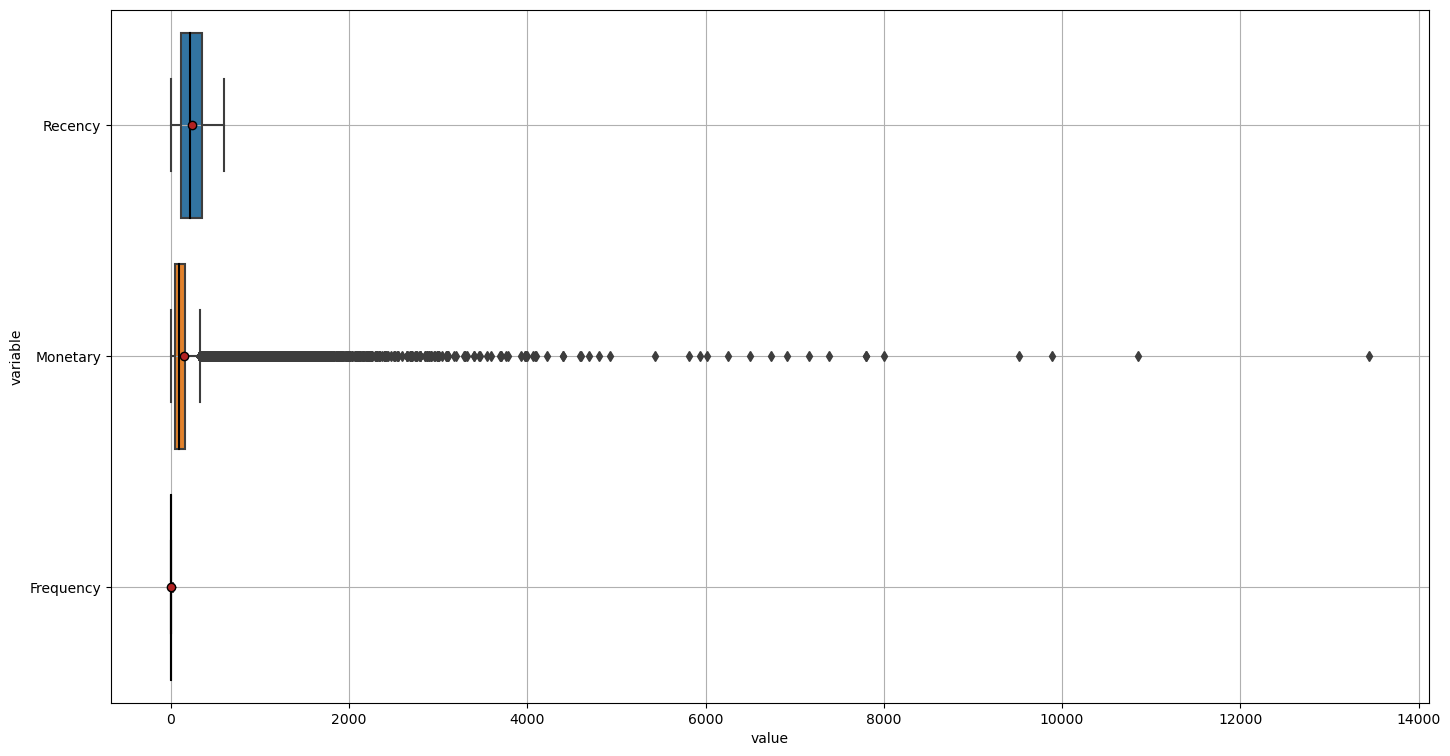

In [9]:
temp3 = pd.melt(rfm)

ordre = rfm.select_dtypes(include=['float64', 'int64']).median(
).sort_values(ascending=False).index.tolist()
plt.figure(figsize=(17, 9))

medianprops = {'color': "black"}
meanprops = {'marker': 'o', 'markeredgecolor': 'black',
             'markerfacecolor': 'firebrick'}

sns.boxplot(y="variable", x="value", showfliers=True, medianprops=medianprops,
            order=ordre, showmeans=True, meanprops=meanprops, orient='h', data=temp3)

plt.grid(True)
plt.draw()
# plt.savefig("7.jpg")

#### Creation de rfm_normalized contenant les donnees RFM normalisées

In [10]:
std_scale = preprocessing.StandardScaler().fit(rfm)
rfm_scaled = std_scale.transform(rfm)
rfm_normalized = pd.DataFrame(
    rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_normalized

Recency  Frequency  Monetary
0     -0.828683  -0.158998 -0.072915
1     -0.808811  -0.158998 -0.530169
2      1.993221  -0.158998 -0.323787
3      0.562397  -0.158998 -0.500963
4      0.343798  -0.158998  0.133467
...         ...        ...       ...
92499  1.397044  -0.158998  5.859436
92500  0.171569  -0.158998 -0.340718
92501  2.198571  -0.158998 -0.237692
92502 -0.775690  -0.158998 -0.134294
92503  1.642139  -0.158998 -0.373261

[92504 rows x 3 columns]

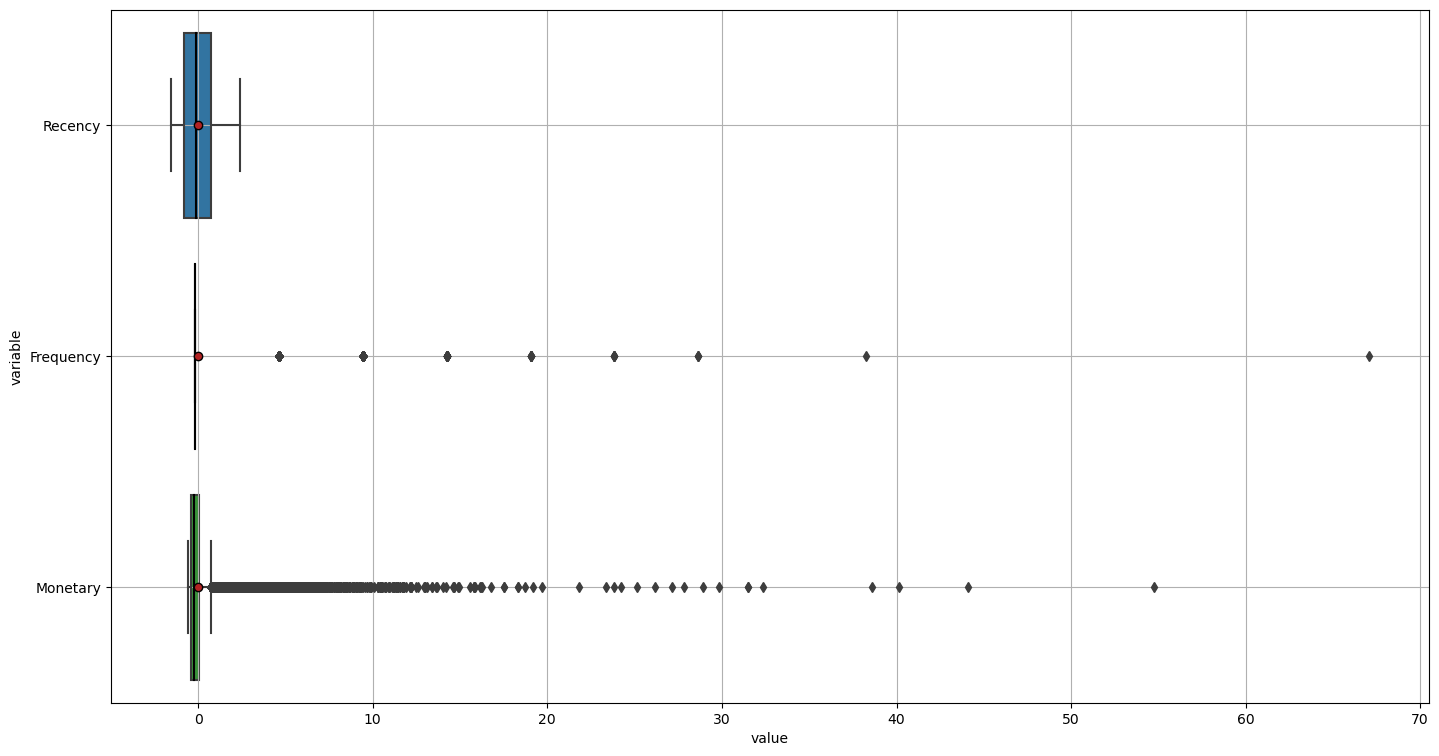

In [11]:
temp3 = pd.melt(rfm_normalized)

ordre = rfm_normalized.select_dtypes(include=['float64', 'int64']).median(
).sort_values(ascending=False).index.tolist()
plt.figure(figsize=(17, 9))

medianprops = {'color': "black"}
meanprops = {'marker': 'o', 'markeredgecolor': 'black',
             'markerfacecolor': 'firebrick'}

sns.boxplot(y="variable", x="value", showfliers=True, medianprops=medianprops,
            order=ordre, showmeans=True, meanprops=meanprops, orient='h', data=temp3)

plt.grid(True)
plt.draw()
# plt.savefig("7.jpg")

### ACP

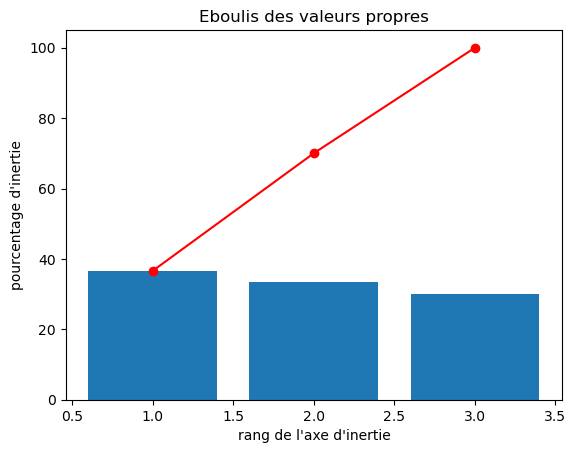

In [12]:
# choix du nombre de composantes à calculer
n_comp = 3

# selection des colonnes à prendre en compte dans l'ACP
data_pca = rfm_normalized

# préparation des données pour l'ACP
X = data_pca.values
names = data_pca.index  # ou data.index pour avoir les intitulés
features = data_pca.columns

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X)

# Eboulis des valeurs propres
display_scree_plot(pca)

# plt.savefig("eboulis.jpg")

#### Proportion de la variance expliquée

In [13]:
print(pca.explained_variance_ratio_)
# La premiere composante contient 36 % de l'information disponible et disposons de 70% avec les deux premiers facteurs.

[0.36652141 0.33392121 0.29955738]


#### Cercle des corrélations

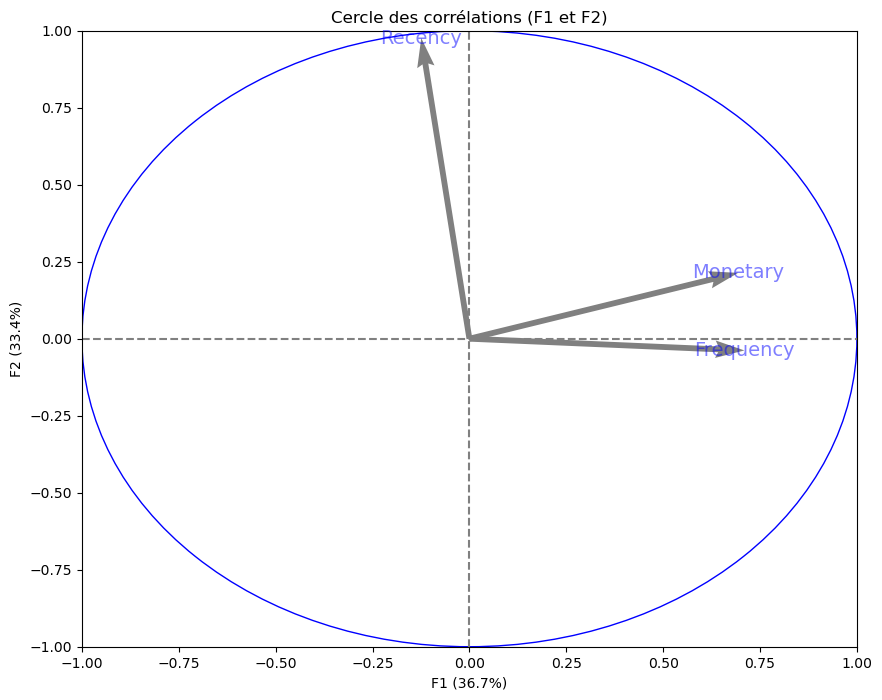

In [14]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [
                (0, 1), (2, 3), (4, 5)], labels=np.array(features))

# plt.savefig("cercles.jpg")

### Représentation des individus par les plans factoriels

#### Avec l'ACP

In [15]:
X_projected = pca.transform(X)
data_info = pd.DataFrame(X_projected, columns=['acp_F1', 'acp_F2', 'acp_F3'])
data_info.drop('acp_F3', axis=1, inplace=True)
data_info.index = names

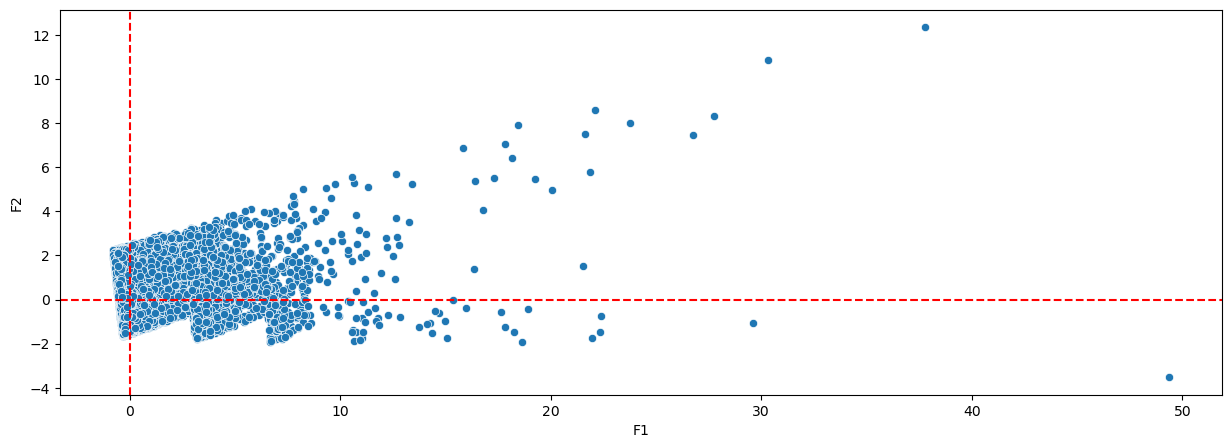

In [90]:
x = data_info['acp_F1']
y = data_info['acp_F2']
fig, scatter = plt.subplots(figsize=(15, 5), dpi=100)
scatter = sns.scatterplot(x=x, y=y, data=data_info, s=35)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("F1")
plt.ylabel("F2")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3)
plt.draw()

#### Avec TSNE

In [17]:
debut = datetime.datetime.now()

X = rfm_normalized.copy()

tsne = TSNE(n_components=2, perplexity=30)
embedding = tsne.fit_transform(X)
data_info['tsne_F1'] = embedding[:, 0]
data_info['tsne_F2'] = embedding[:, 1]

fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps:_________________ 0:04:48.066836


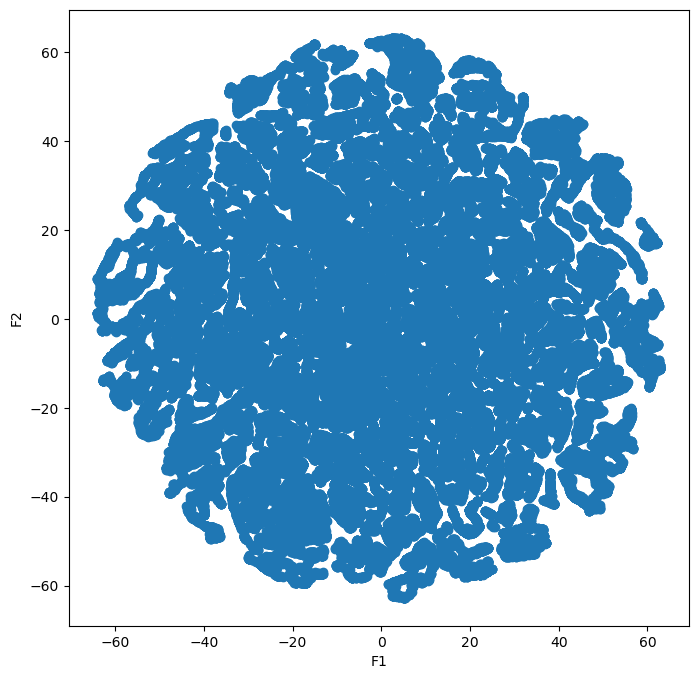

In [88]:
plt.figure(figsize=(8, 8))

plt.scatter(data_info['tsne_F1'], data_info['tsne_F2'])
plt.xlabel("F1")
plt.ylabel("F2")
plt.show()

In [19]:
# creation de data_info qui contient acp,tnse et rfm normalisé

data_info = data_info.join(rfm_normalized)
data_info

acp_F1    acp_F2    tsne_F1    tsne_F2   Recency  Frequency  Monetary
0     -0.060441 -0.818432  -6.202276  50.827129 -0.828683  -0.158998 -0.072915
1     -0.380008 -0.896825 -11.145341  60.381302 -0.808811  -0.158998 -0.530169
2     -0.585031  1.882432 -33.353279 -13.488730  1.993221  -0.158998 -0.323787
3     -0.530123  0.447883  41.853157  41.418198  0.562397  -0.158998 -0.500963
4     -0.062997  0.370189   1.705921 -25.734119  0.343798  -0.158998  0.133467
...         ...       ...        ...        ...       ...        ...       ...
92499  3.776998  2.622881   3.343681  58.062122  1.397044  -0.158998  5.859436
92500 -0.370437  0.100660  33.024761 -32.653332  0.171569  -0.158998 -0.340718
92501 -0.550840  2.101291 -39.149666 -10.347350  2.198571  -0.158998 -0.237692
92502 -0.109591 -0.779831  -3.301273  47.938049 -0.775690  -0.158998 -0.134294
92503 -0.575720  1.529153 -41.663742 -35.558537  1.642139  -0.158998 -0.373261

[92504 rows x 7 columns]

#### Sauvegarde data_info contien acp,tnse et rfm normalisé

In [20]:
data_info.to_csv('data_info_rfm.csv')

#### Sauvegarde dataset clients avec valeurs numeriques

In [21]:
num_cust.to_csv('num_cust_rfm.csv')

### Application de l'algorithme de classification Kmeans.

#### Recherche du meilleur k

In [22]:
X = rfm_normalized.values

ssd = []
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

#### Avec la methode du coude

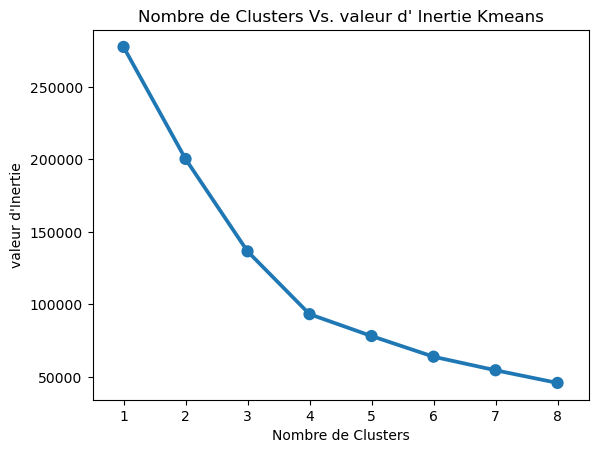

In [23]:
sns.pointplot(x=range_n_clusters, y=ssd)
plt.xlabel('Nombre de Clusters')
plt.ylabel("valeur d'Inertie")
plt.title("Nombre de Clusters Vs. valeur d' Inertie Kmeans")
plt.draw()
#plt.savefig("coude inertie.jpg",bbox="tight")

#### Analyses silhouette

For n_clusters = 2 The average silhouette_score is : 0.7466892122976176
For n_clusters = 3 The average silhouette_score is : 0.46942008141681035
For n_clusters = 4 The average silhouette_score is : 0.49724267763667285
For n_clusters = 5 The average silhouette_score is : 0.5071107631123358
For n_clusters = 6 The average silhouette_score is : 0.4496059752995348
For n_clusters = 7 The average silhouette_score is : 0.4526359973431412
For n_clusters = 8 The average silhouette_score is : 0.4565773744995662


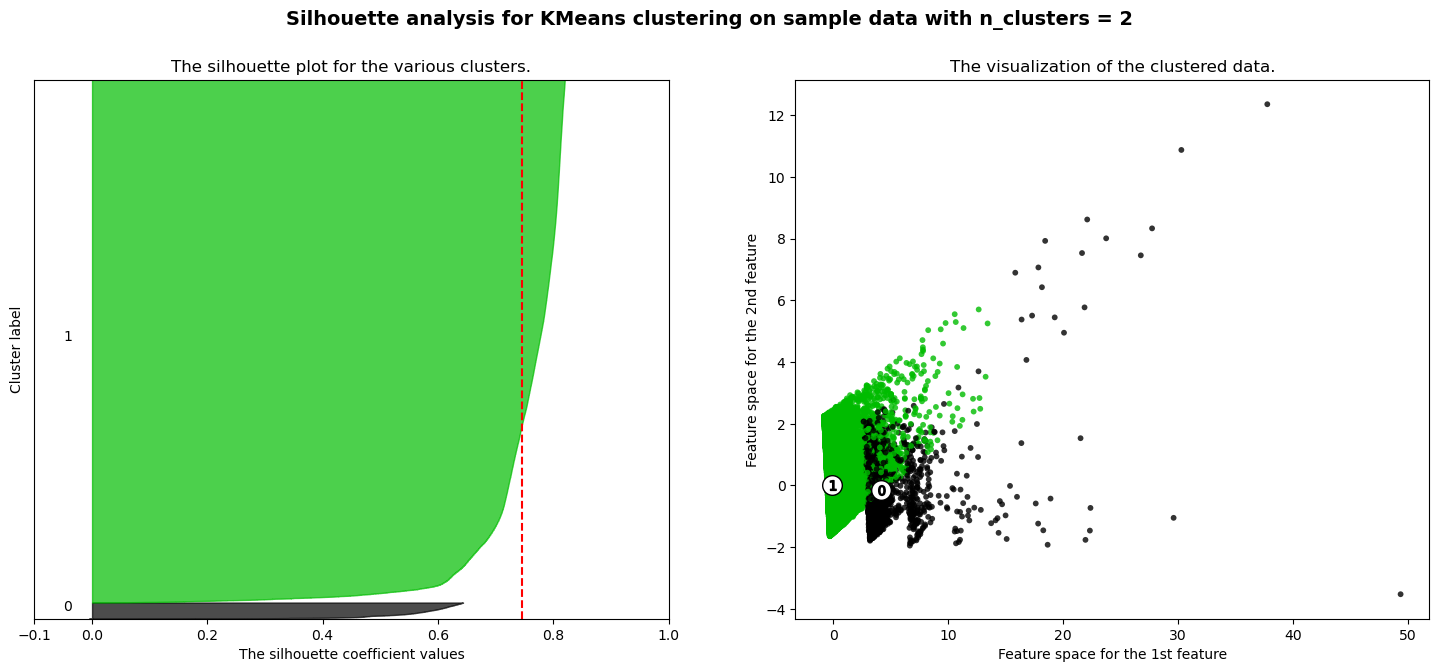

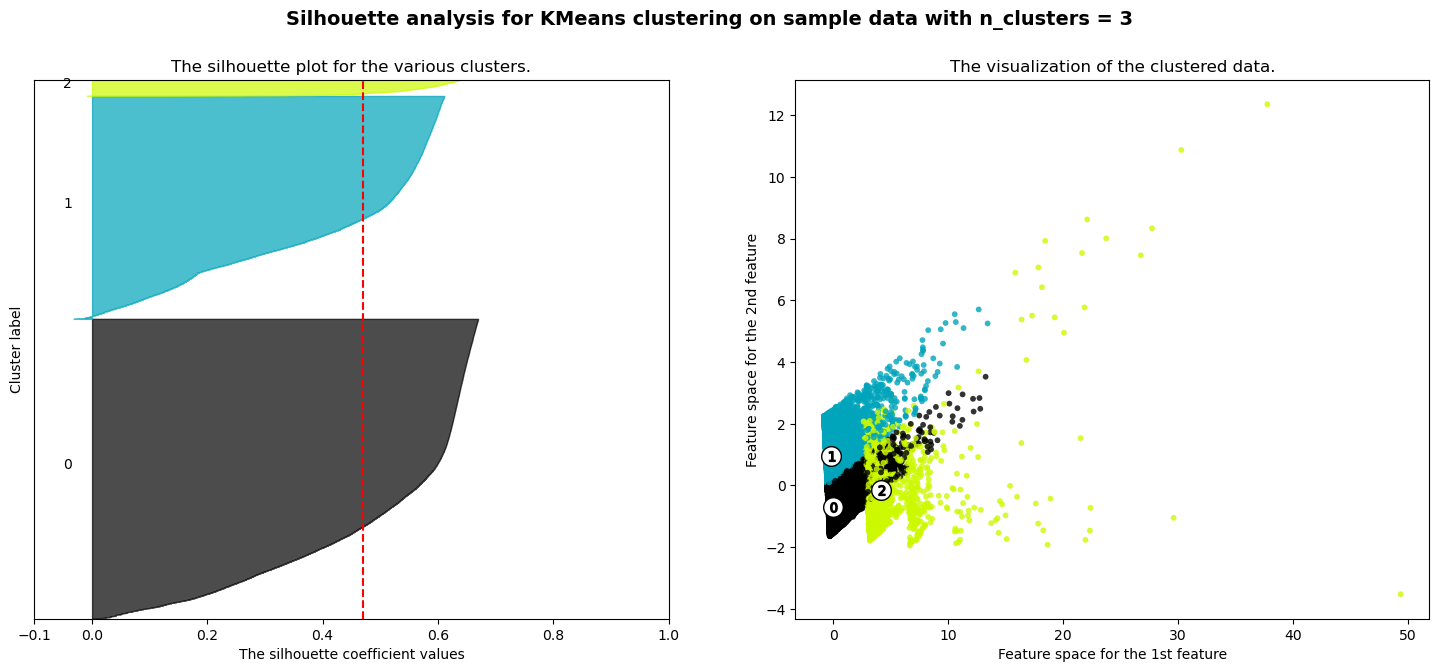

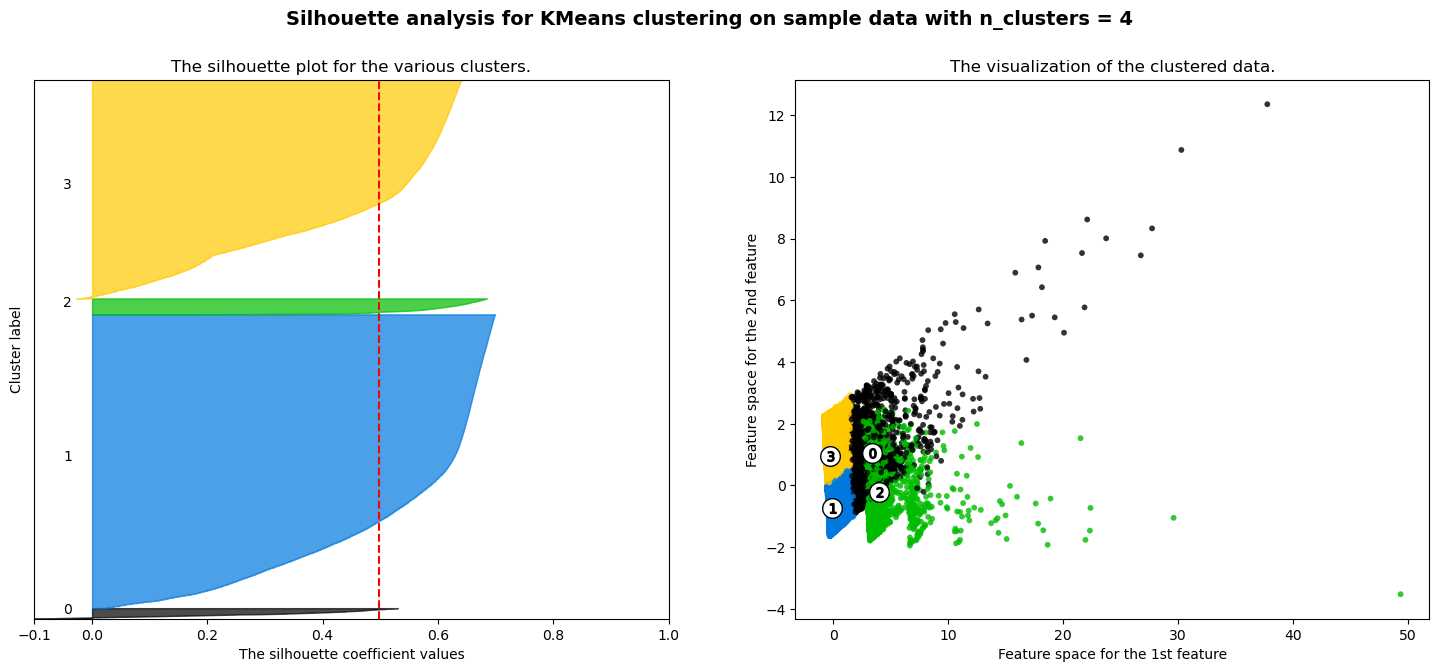

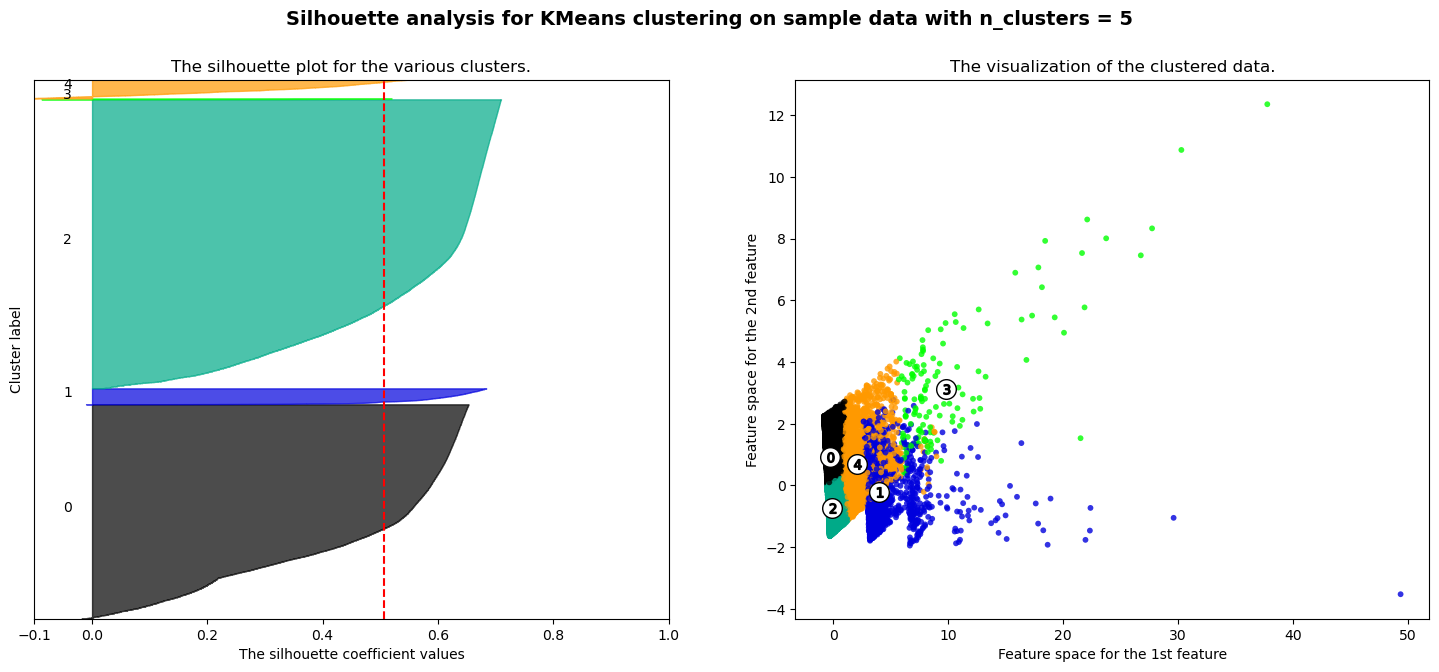

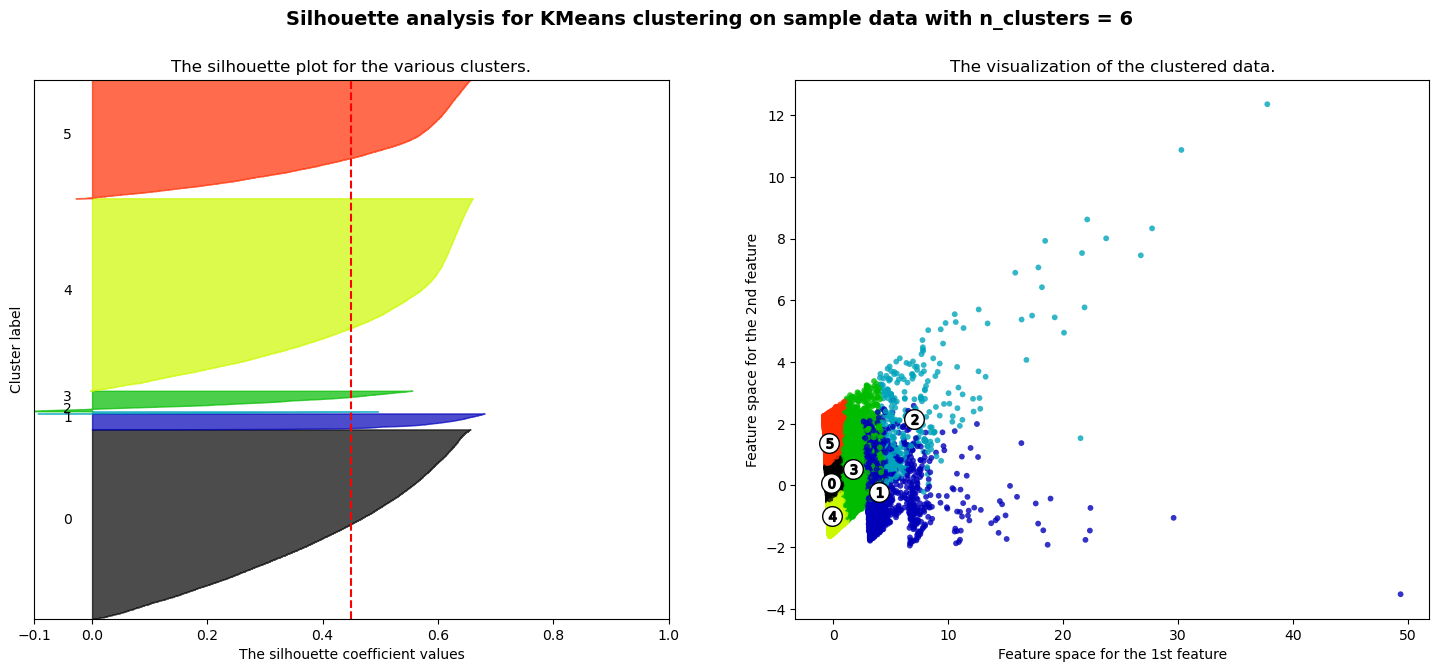

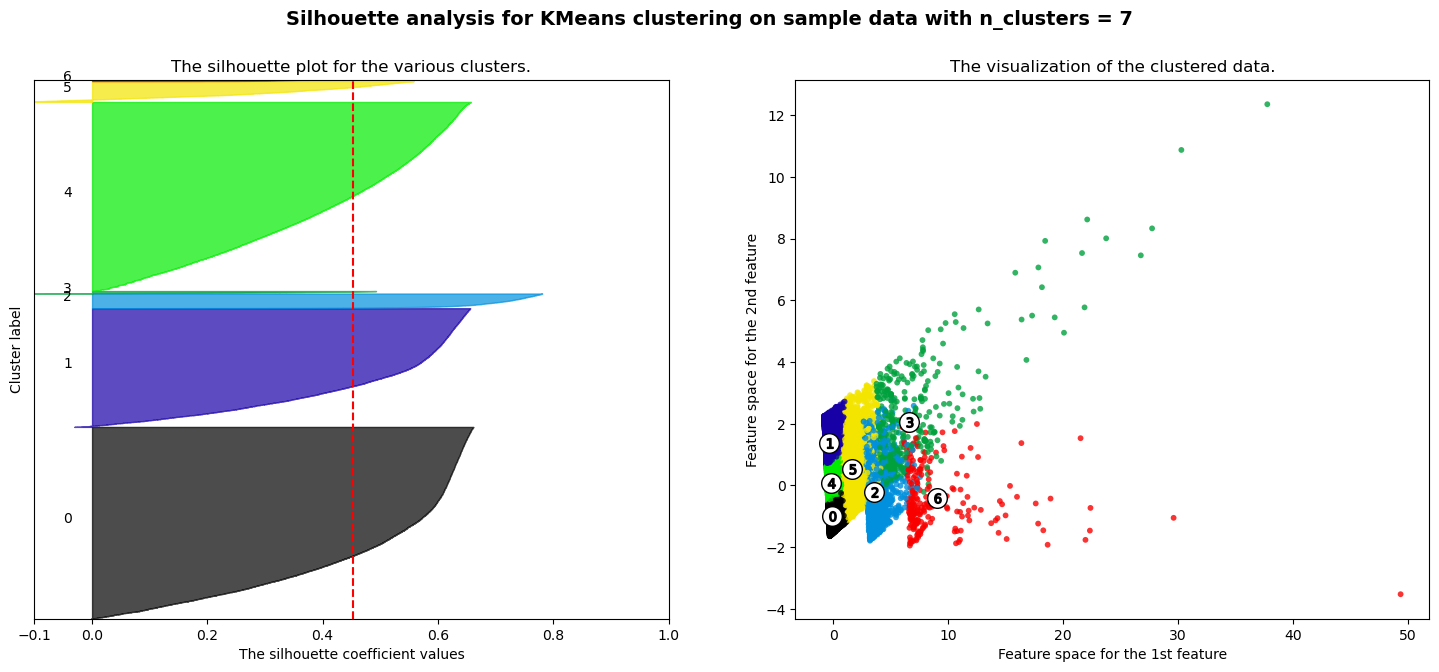

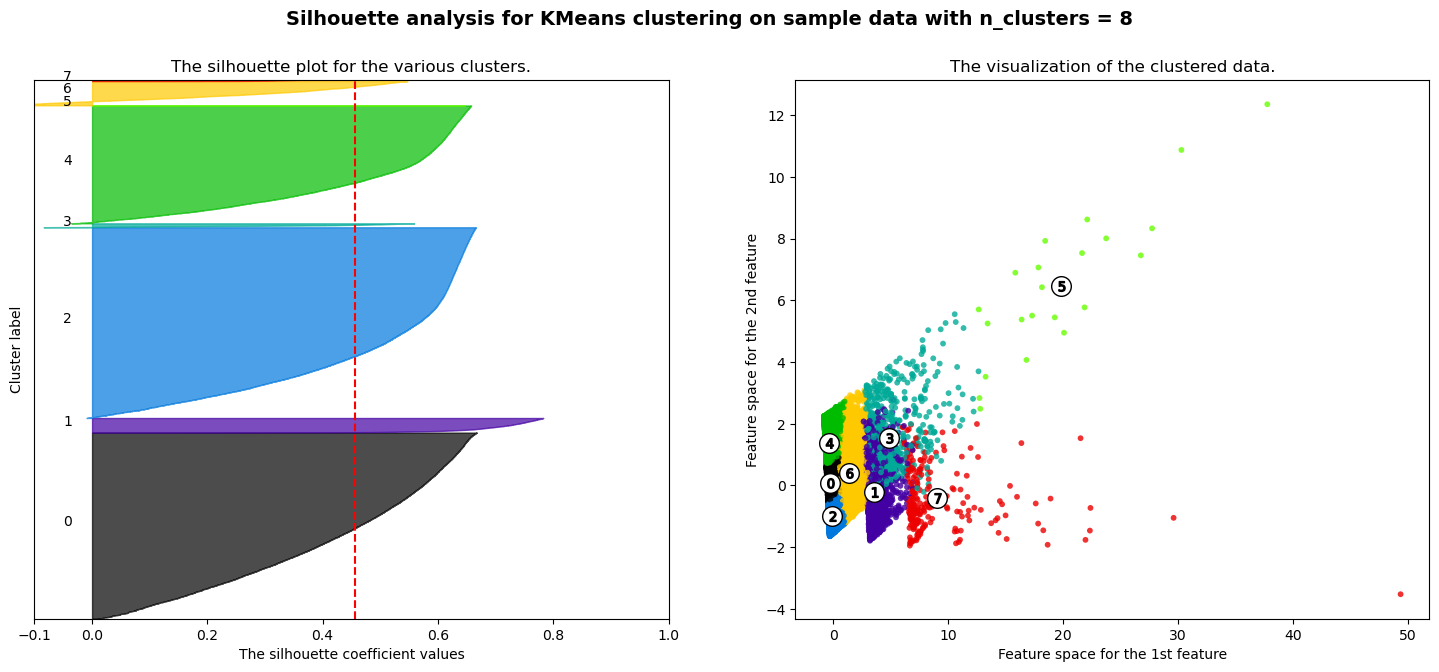

temps:_________________ 0:19:42.282631


In [24]:
debut = datetime.datetime.now()

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data_info['acp_F1'], data_info['acp_F2'], marker=".", s=70, lw=0, alpha=0.8, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    cent = clusterer.cluster_centers_
    centers = pca.transform(cent)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" %
                    i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

#### Clusterisation avec KMeans k=3

In [25]:
kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
                n_clusters=3, n_init=10, random_state=None, tol=0.0001, verbose=0)

kmeans.fit(X)

y_kmeans = kmeans.fit_predict(X)

k_centro = kmeans.cluster_centers_
k_cent = pca.transform(k_centro)

#### Affectation des données aux datasets et sauvegarde

In [26]:
data_info['km_cluster'] = y_kmeans
num_cust['km_cluster'] = y_kmeans
rfm['km_cluster'] = y_kmeans

data_info.to_csv('data_info_rfm.csv')
num_cust.to_csv('num_cust_rfm.csv')
rfm.to_csv('rfm_clus.csv')

### Clusterisation Hyerarchique

#### Affichage du dindrogramme afin de definir le nombre optimal de clusters

temps:_________________ 2:18:58.300968


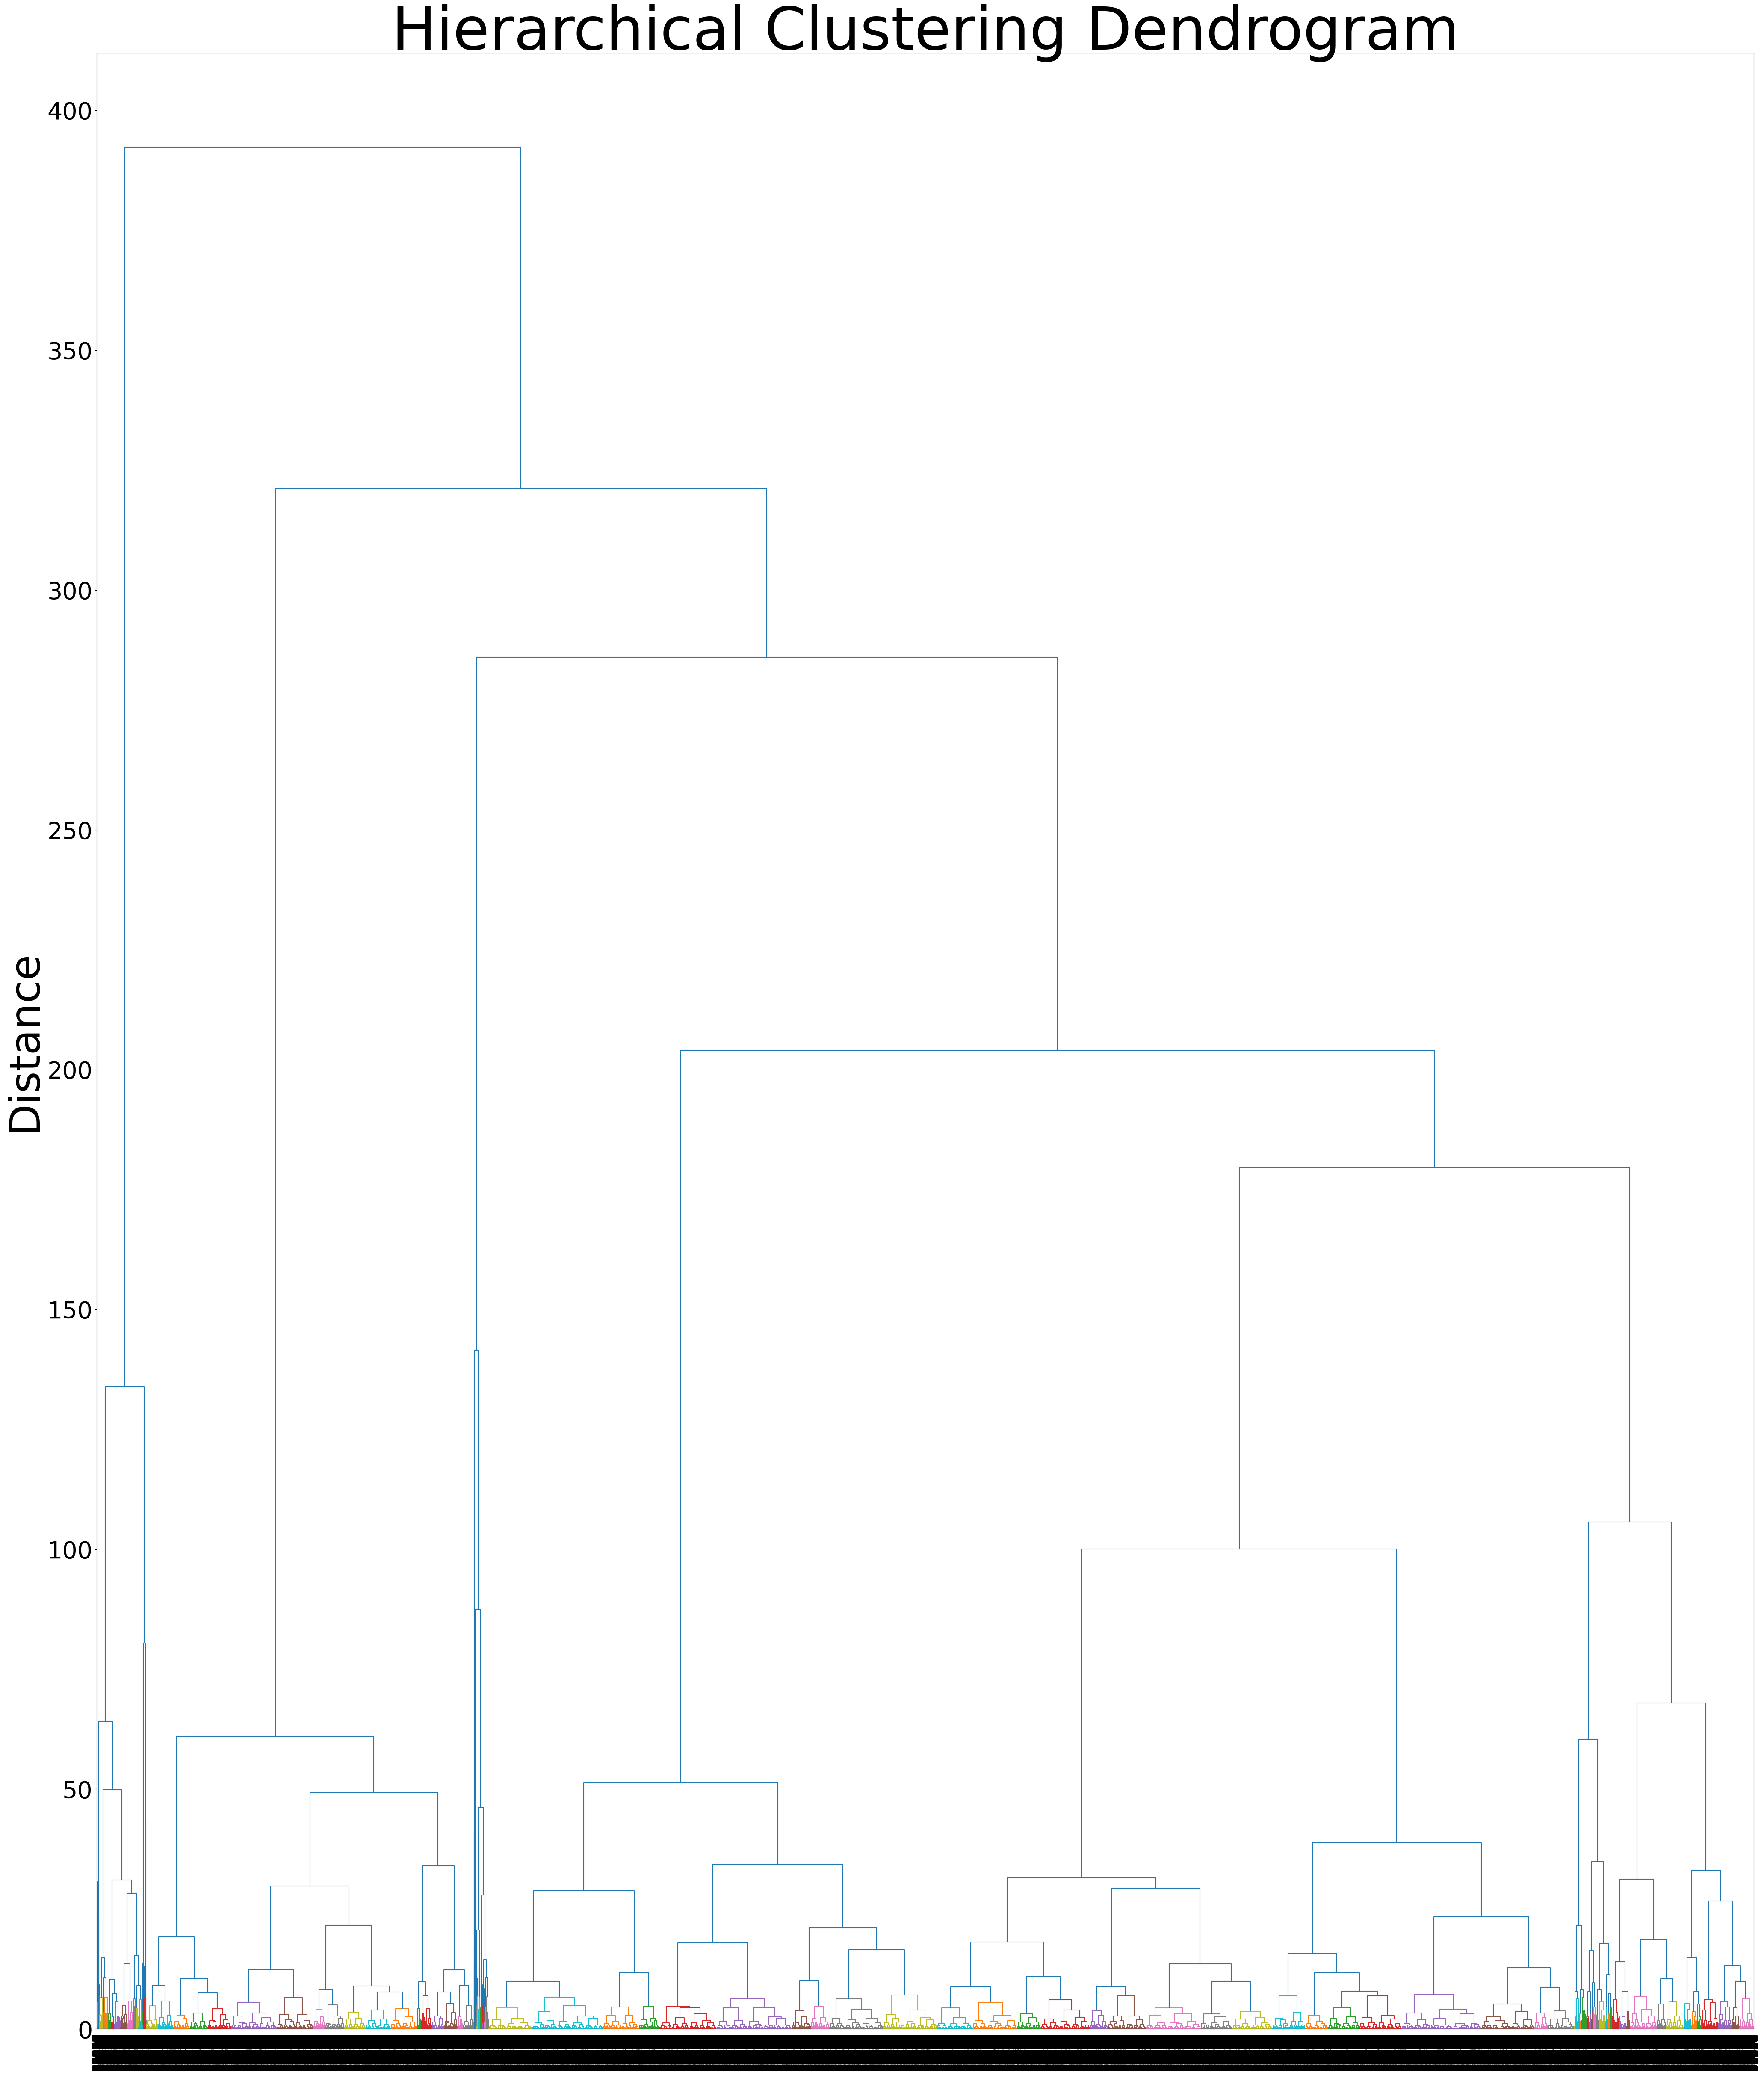

In [27]:
debut = datetime.datetime.now()

# préparation des données pour le clustering
X = rfm_normalized.values
names = rfm_normalized.index

# Clustering hiérarchique
Z = linkage(X, 'ward')


# Affichage du dendrogramme
plot_dendrogram(Z, names)


plt.savefig("P5_dindogramme_rfm.jpg")
fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

#### Decoupage du dendrogramme en 4 clusters

In [28]:
hclusters = fcluster(Z, 4, criterion='maxclust')

#### Affectation des données aux datasets et sauvegarde

In [29]:
data_info['h_cluster'] = hclusters
num_cust['h_cluster'] = hclusters
rfm['h_cluster'] = hclusters

data_info.to_csv('data_info_rfm.csv')
num_cust.to_csv('num_cust_rfm.csv')
rfm.to_csv('rfm_clus.csv')

### Clusterisation avec DBSCAN

#### Optimisation des hyperparametres : recherche du meilleur epsilon et min_samples

In [30]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

In [31]:
len(distances)

92504

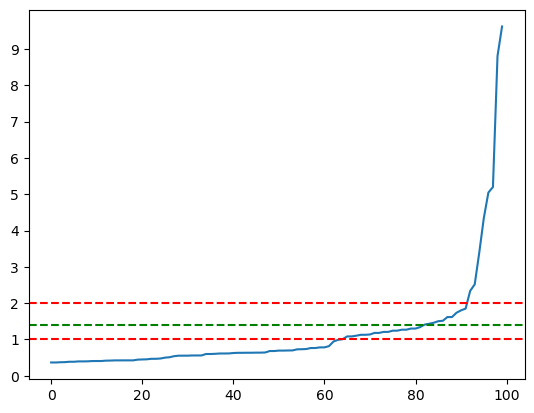

In [32]:
distances = np.sort(distances, axis=0)
distances = distances[92402:92502,1]
plt.plot(distances)
plt.yticks(np.arange(0, 10, 1))
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=1.4, color='g', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--');
#La valeur optimale pour epsilon sera trouvée au point de courbure maximale.

#### epsilon = 1

In [33]:
debut = datetime.datetime.now()

min_samp = []
clu = []
bruit = []

X = rfm_normalized.values

for i in range(1, 14):
    epsilon = 1
    min_samples = i
    
    # Compute DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=min_samples,
            metric='euclidean', n_jobs=-1).fit(X)
    labels = db.labels_
    
    no_clusters = len(np.unique(labels))
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    
    min_samp.append(i)
    clu.append(no_clusters)
    bruit.append(no_noise)
    
df_DBSCAN = pd.DataFrame()
df_DBSCAN['min_samples'] = min_samp
df_DBSCAN['no_clusters'] = clu
df_DBSCAN['no_noise'] = bruit



fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

temps:_________________ 0:45:23.662417


In [34]:
df_DBSCAN

min_samples  no_clusters  no_noise
0             1           49         0
1             2           12        38
2             3           11        40
3             4            9        50
4             5            8        58
5             6            7        69
6             7            5        84
7             8            5        85
8             9            5        85
9            10            5        89
10           11            5        93
11           12            5        96
12           13            5       102

#### epsilon = 1.4

In [35]:
debut = datetime.datetime.now()

min_samp = []
clu = []
bruit = []

X = rfm_normalized.values

for i in range(1, 13):
    epsilon = 1.4
    min_samples = i
    
    # Compute DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=min_samples,
            metric='euclidean', n_jobs=-1).fit(X)
    labels = db.labels_
    
    no_clusters = len(np.unique(labels))
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    
    min_samp.append(i)
    clu.append(no_clusters)
    bruit.append(no_noise)
    
df_DBSCAN = pd.DataFrame()
df_DBSCAN['min_samples'] = min_samp
df_DBSCAN['no_clusters'] = clu
df_DBSCAN['no_noise'] = bruit



fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

temps:_________________ 1:08:10.039688


In [36]:
df_DBSCAN

min_samples  no_clusters  no_noise
0             1           35         0
1             2           16        20
2             3            9        34
3             4            7        40
4             5            6        45
5             6            6        51
6             7            6        52
7             8            6        62
8             9            6        62
9            10            5        70
10           11            5        72
11           12            5        73

#### Application des hyperparametres optimaux pour DBSCAN

In [37]:
debut = datetime.datetime.now()

X = rfm_normalized.values

epsilon = 1.4
min_samples = 10

# Compute DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples,
            metric='euclidean', n_jobs=-1).fit(X)
labels = db.labels_

no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

fin = datetime.datetime.now()
print("temps:_________________", fin-debut)

Estimated no. of clusters: 5
Estimated no. of noise points: 70
temps:_________________ 0:05:47.208724


#### Affectation des données aux datasets et sauvegarde

In [38]:
data_info['db_cluster'] = labels
num_cust['db_cluster'] = labels
rfm['db_cluster'] = labels

data_info.to_csv('data_info_rfm.csv')
num_cust.to_csv('num_cust_rfm.csv')
rfm.to_csv('rfm_clus.csv')

### Representation des 3 clustering en 2 dimensions (obtenue par l'acp)

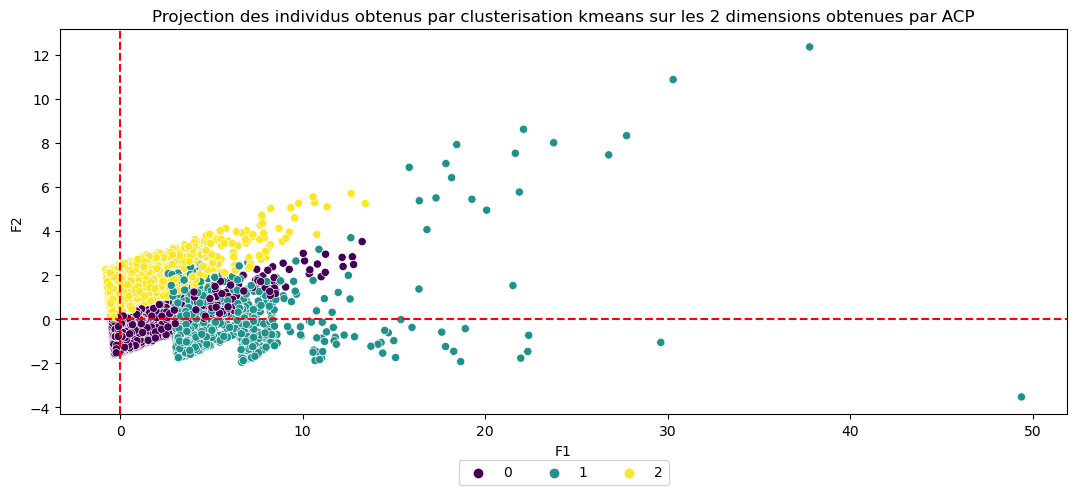

In [86]:
x = data_info['acp_F1']
y = data_info['acp_F2']

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=data_info, hue='km_cluster', s=35,
                          palette='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
plt.title("Projection des individus obtenus par clusterisation kmeans sur les 2 dimensions obtenues par ACP")
plt.draw()

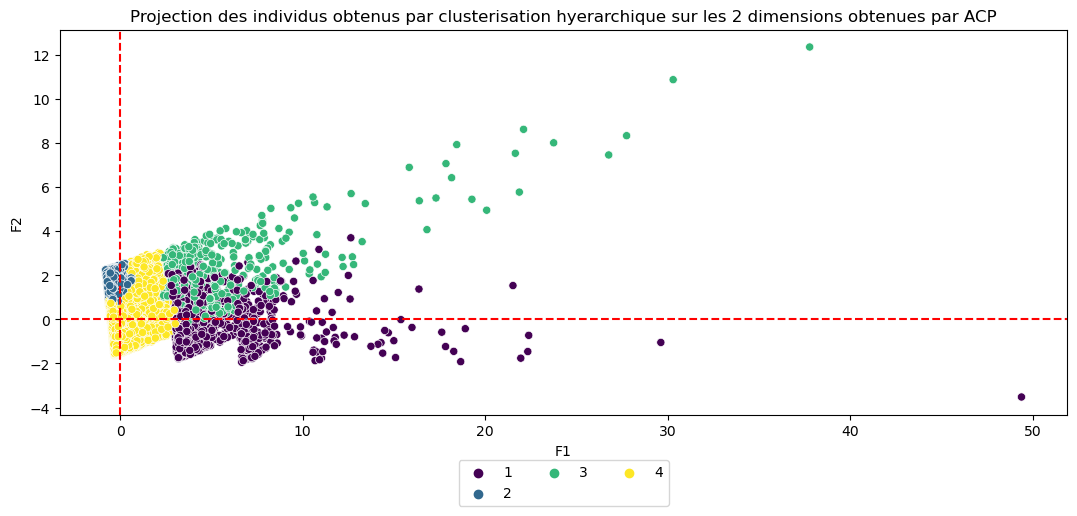

In [81]:
x = data_info['acp_F1']
y = data_info['acp_F2']

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=data_info, hue='h_cluster', s=35,
                          palette='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
plt.title("Projection des individus obtenus par clusterisation hyerarchique sur les 2 dimensions obtenues par ACP")
plt.draw()

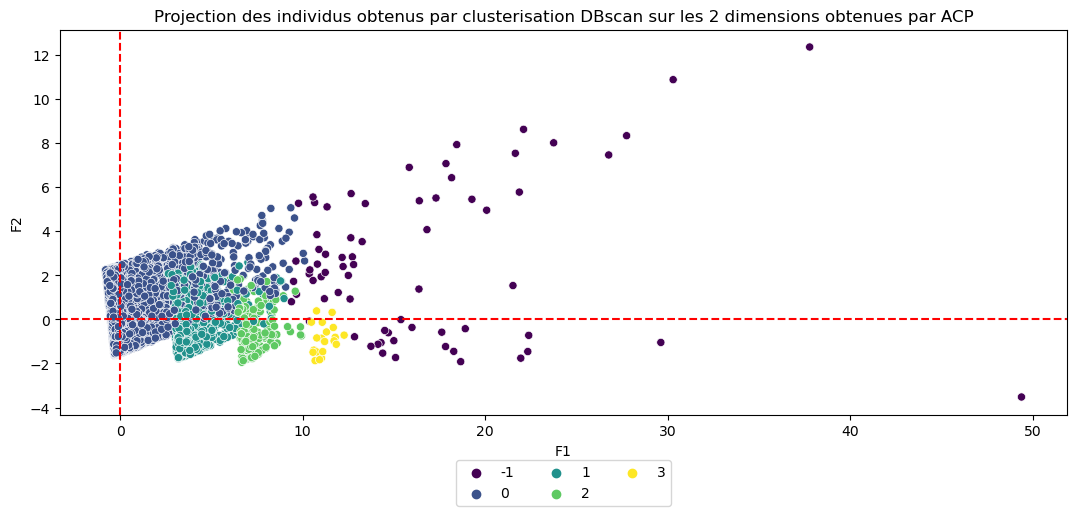

In [82]:
x = data_info['acp_F1']
y = data_info['acp_F2']

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=data_info, hue='db_cluster', s=35,
                          palette='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
plt.title("Projection des individus obtenus par clusterisation DBscan sur les 2 dimensions obtenues par ACP")
plt.draw()

### Representation des 3 clustering en 2 dimensions (obtenue par TSNE)

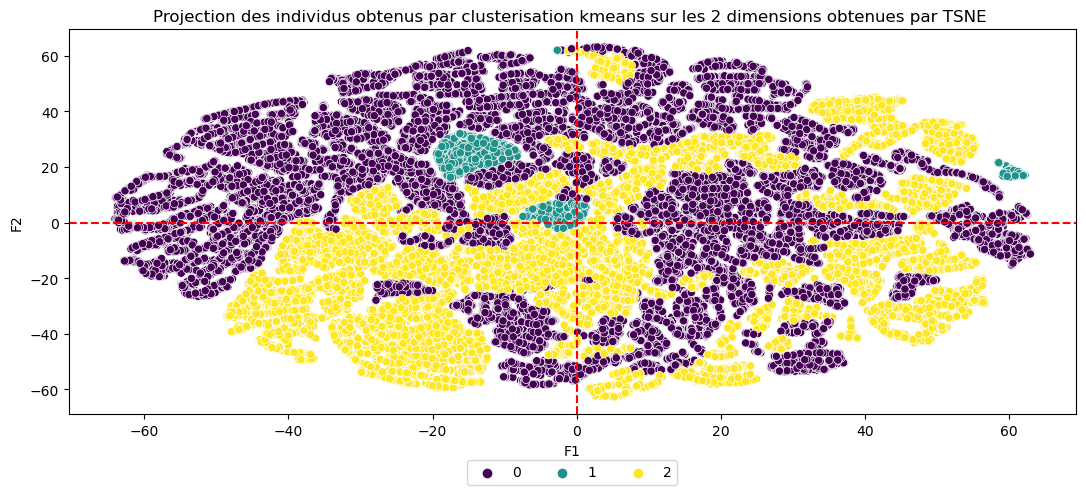

In [93]:
x = data_info['tsne_F1']
y = data_info['tsne_F2']

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=data_info, hue='km_cluster', s=35,
                          palette='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
plt.title("Projection des individus obtenus par clusterisation kmeans sur les 2 dimensions obtenues par TSNE ")
plt.draw()

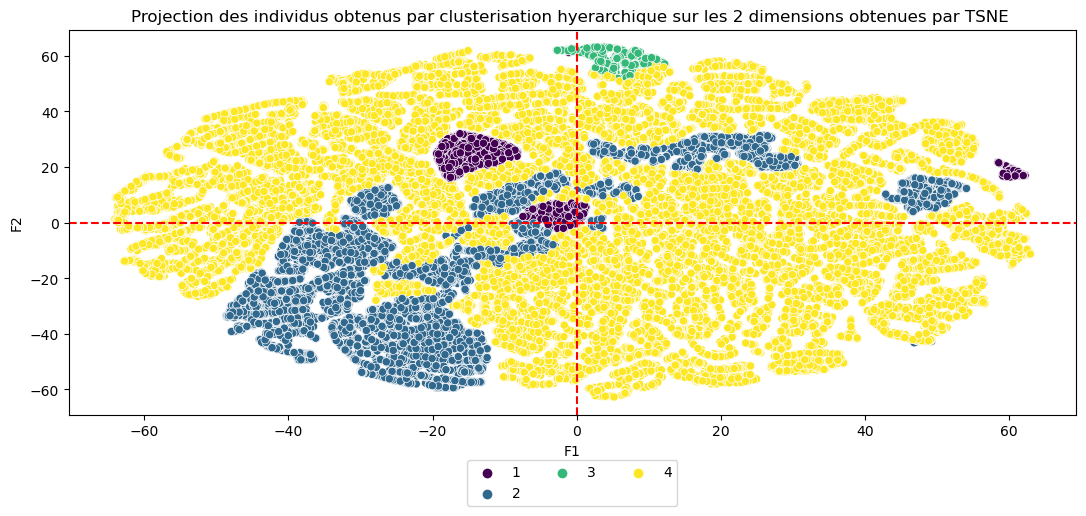

In [96]:
x = data_info['tsne_F1']
y = data_info['tsne_F2']

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=data_info, hue='h_cluster', s=35,
                          palette='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
plt.title("Projection des individus obtenus par clusterisation hyerarchique sur les 2 dimensions obtenues par TSNE ")
plt.draw()

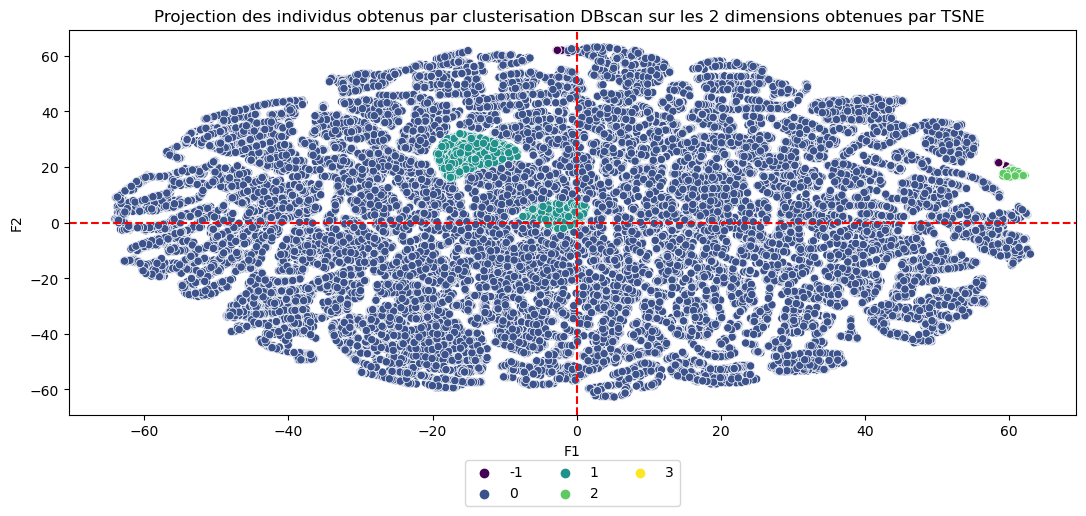

In [97]:
x = data_info['tsne_F1']
y = data_info['tsne_F2']

fig, scatter = plt.subplots(figsize=(13, 5), dpi=100)

scatter = sns.scatterplot(x=x, y=y, data=data_info, hue='db_cluster', s=35,
                          palette='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3)
plt.title("Projection des individus obtenus par clusterisation DBscan sur les 2 dimensions obtenues par TSNE ")
plt.draw()

### Tableaux des moyennes par clusterisation

#### Moyennes obtenues avec la clusterisation Kmeans

In [45]:
rfm.groupby('km_cluster').agg(Recency_m=('Recency', np.mean), Frequency_m=('Frequency', np.mean), Monetary_m=(
    'Monetary', np.mean), nb_clients=('km_cluster', np.size))

Recency_m  Frequency_m  Monetary_m  nb_clients
km_cluster                                                 
0           126.939824     1.000000  140.632719       51466
1           219.647633     2.107336  313.825688        2767
2           384.084659     1.000000  144.952456       38271

#### Moyennes obtenues avec la clusterisation Hyerarchique

In [49]:
rfm.groupby('h_cluster').agg(Recency_m=('Recency', np.mean), Frequency_m=('Frequency', np.mean), Monetary_m=(
    'Monetary', np.mean), Nb_clients=('h_cluster', np.size))

Recency_m  Frequency_m   Monetary_m  Nb_clients
h_cluster                                                  
1          219.026909     2.113455   267.968029        2750
2          461.758122     1.000000   111.420522       18315
3          266.244114     1.002478  1864.658302         807
4          177.906204     1.000000   132.677490       70632

#### Moyennes obtenues avec la clusterisation DBSCAN

In [50]:
rfm.groupby('db_cluster').agg(Recency_m=('Recency', np.mean), Frequency_m=('Frequency', np.mean), Monetary_m=(
    'Monetary', np.mean), Nb_clients=('db_cluster', np.size))

Recency_m  Frequency_m   Monetary_m  Nb_clients
db_cluster                                                  
-1          237.471429     2.985714  3544.941429          70
 0          236.608299     1.000000   141.657692       89719
 1          220.462574     2.000000   248.634986        2525
 2          211.341176     3.000000   344.755824         170
 3          133.750000     4.000000   484.520500          20

#### en cas de crash dbscan pour relancer

In [55]:
data_info = pd.read_csv('data_info_rfm.csv', delimiter = ',', encoding="utf8",index_col = 0)
num_cust = pd.read_csv('num_cust_rfm.csv', delimiter = ',', encoding="utf8",index_col = 0)
rfm= pd.read_csv('rfm_clus.csv', delimiter = ',', encoding="utf8",index_col = 0)

In [56]:
data_info.head()

acp_F1    acp_F2    tsne_F1    tsne_F2   Recency  Frequency  Monetary  \
0 -0.060441 -0.818432  -6.202276  50.827130 -0.828683  -0.158998 -0.072915   
1 -0.380008 -0.896825 -11.145341  60.381300 -0.808811  -0.158998 -0.530169   
2 -0.585031  1.882432 -33.353280 -13.488730  1.993221  -0.158998 -0.323787   
3 -0.530123  0.447883  41.853157  41.418198  0.562397  -0.158998 -0.500963   
4 -0.062997  0.370189   1.705921 -25.734120  0.343798  -0.158998  0.133467   

   km_cluster  h_cluster  db_cluster  
0           0          4           0  
1           0          4           0  
2           2          2           0  
3           2          4           0  
4           2          4           0

In [57]:
num_cust.head()

note_moy  Monetary  qtés  Recency  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2       5.0    129.90     1      111   
0000b849f77a49e4a4ce2b2a4ca5be3f       4.0     18.90     1      114   
0000f46a3911fa3c0805444483337064       3.0     69.00     1      537   
0000f6ccb0745a6a4b88665a16c9f078       4.0     25.99     1      321   
0004aac84e0df4da2b147fca70cf8255       5.0    180.00     1      288   

                                  Frequency  km_cluster  h_cluster  db_cluster  
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2          1           0          4           0  
0000b849f77a49e4a4ce2b2a4ca5be3f          1           0          4           0  
0000f46a3911fa3c0805444483337064          1           2          2           0  
0000f6ccb0745a6a4b88665a16c9f078          1           2          4           0  
0004aac84e0df4da2b147fca70cf8255          1           2          4           0

In [58]:
rfm.head()

Recency  Frequency  Monetary  km_cluster  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90           0   
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90           0   
0000f46a3911fa3c0805444483337064      537          1     69.00           2   
0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99           2   
0004aac84e0df4da2b147fca70cf8255      288          1    180.00           2   

                                  h_cluster  db_cluster  
customer_unique_id                                       
0000366f3b9a7992bf8c76cfdf3221e2          4           0  
0000b849f77a49e4a4ce2b2a4ca5be3f          4           0  
0000f46a3911fa3c0805444483337064          2           0  
0000f6ccb0745a6a4b88665a16c9f078          4           0  
0004aac84e0df4da2b147fca70cf8255          4           0

In [59]:
rfm_normalized = data_info.iloc[:,4:7].copy()
rfm_normalized

Recency  Frequency  Monetary
0     -0.828683  -0.158998 -0.072915
1     -0.808811  -0.158998 -0.530169
2      1.993221  -0.158998 -0.323787
3      0.562397  -0.158998 -0.500963
4      0.343798  -0.158998  0.133467
...         ...        ...       ...
92499  1.397044  -0.158998  5.859436
92500  0.171569  -0.158998 -0.340718
92501  2.198571  -0.158998 -0.237692
92502 -0.775690  -0.158998 -0.134294
92503  1.642139  -0.158998 -0.373261

[92504 rows x 3 columns]

In [7]:
X = rfm_normalized.values

In [51]:
num_cust

note_moy  Monetary  qtés  Recency  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2       5.0    129.90     1      111   
0000b849f77a49e4a4ce2b2a4ca5be3f       4.0     18.90     1      114   
0000f46a3911fa3c0805444483337064       3.0     69.00     1      537   
0000f6ccb0745a6a4b88665a16c9f078       4.0     25.99     1      321   
0004aac84e0df4da2b147fca70cf8255       5.0    180.00     1      288   
...                                    ...       ...   ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684       5.0   1570.00     2      447   
fffea47cd6d3cc0a88bd621562a9d061       4.0     64.89     1      262   
ffff371b4d645b6ecea244b27531430a       5.0     89.90     1      568   
ffff5962728ec6157033ef9805bacc48       5.0    115.00     1      119   
ffffd2657e2aad2907e67c3e9daecbeb       5.0     56.99     1      484   

                                  Frequency  km_cluster  h_cluster  db_cluster  
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2          1           0          4           0  
0000b849f77a49e4a4ce2b2a4ca5be3f          1           0          4           0  
0000f46a3911fa3c0805444483337064          1           2          2           0  
0000f6ccb0745a6a4b88665a16c9f078          1           2          4           0  
0004aac84e0df4da2b147fca70cf8255          1           2          4           0  
...                                     ...         ...        ...         ...  
fffcf5a5ff07b0908bd4e2dbc735a684          1           2          3           0  
fffea47cd6d3cc0a88bd621562a9d061          1           2          4           0  
ffff371b4d645b6ecea244b27531430a          1           2          2           0  
ffff5962728ec6157033ef9805bacc48          1           0          4           0  
ffffd2657e2aad2907e67c3e9daecbeb          1           2          2           0  

[92504 rows x 8 columns]

#### Maintenance

In [52]:
def score_ari2(kmeans, maint):
    import datetime
    now = datetime.datetime(2018, 8, 30)
    now = pd.to_datetime(now)

    date_model = now - timedelta(days=maint)
    date_model = pd.to_datetime(date_model)

    ref_x = data_sli(date_model)
    ref_x = ref_x[['Recency', 'Frequency', 'Monetary']]

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(ref_x)
    scaled_features_seg = std_scale.transform(ref_x)

    # on initialise notre nouveau kmeans.
    kmeans2 = KMeans(n_clusters=3).fit(scaled_features_seg)

    label_init = kmeans.predict(scaled_features_seg)  # avec l'ancien kmeans

    label_pred = kmeans2.predict(scaled_features_seg)  # avec le nouveau

    return adjusted_rand_score(label_init, label_pred)

In [53]:
days = []
pourcent = []

for i in range(1, 366):
    y = (score_ari2(kmeans, i)) * 100
    days.append(i)
    pourcent.append(y)

df_maint = pd.DataFrame()
df_maint['jour'] = days
df_maint['pourcentage'] = pourcent

Nb de jours pour une maintenance a 90% de validité du modèle : 23 .
Nb de jours pour une maintenance a 80% de validité du modèle : 23 .


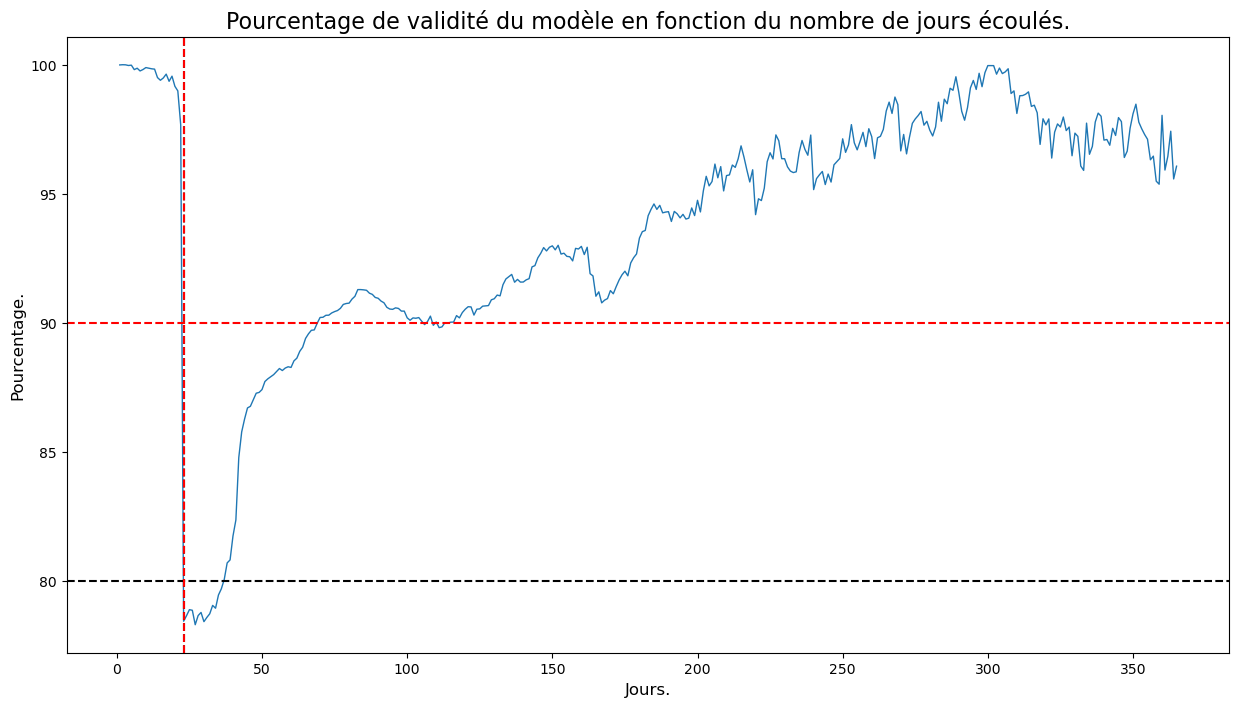

In [54]:
plt.figure(figsize=(15, 8))

b = df_maint[df_maint.pourcentage <= 90].iloc[0, :][0]  # maintenance a 90%
a = df_maint[df_maint.pourcentage <= 80].iloc[0, :][0]  # maintenance a 80%

plt.plot(df_maint['jour'],  df_maint['pourcentage'], lw=1)
plt.axhline(y=80, color='k', linestyle='--')
plt.axhline(y=90, color='r', linestyle='--')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='r', linestyle='--')

plt.xlabel("Jours.",color='k',fontsize=12)
plt.ylabel("Pourcentage.", color='k',fontsize=12)
plt.title("Pourcentage de validité du modèle en fonction du nombre de jours écoulés.", fontsize=16)

print("Nb de jours pour une maintenance a 90% de validité du modèle :", int(b), ".")
print("Nb de jours pour une maintenance a 80% de validité du modèle :", int(a), ".")
plt.draw()